In [1]:

# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 4.1 선형회귀

### python random 모듈 3개 정리

np.random.randint : 균일 분포의 정수 난수 1개 생성

np.random.rand: 0부터 1사이의 균일 분포에서 난수 matrix array 생성

np.random.randn: 가우시안 표준 정규 분포에서 난수 matrix array 생성

In [2]:
import numpy as np

X=2*np.random.rand(100,1)
y=4+3*X+np.random.randn(100,1)

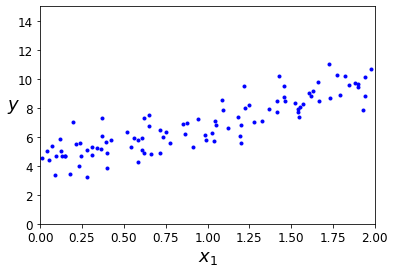

In [3]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

### 정규방정식

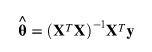

In [4]:
X_b = np.c_[np.ones((100, 1)), X]  # 모든 샘플에 x0 = 1을 추가.
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y) #inv 함수->역행렬 계산 dot함수 -> 행렬 곱셈

In [5]:
# 우리가 생성한 함수 파라미터 값과 매우 비슷하지만 잡음 때문에 원래 함수의 파라미터를 정확하게 재현하지 못함

theta_best 

array([[4.21509616],
       [2.77011339]])

## 새로운 샘플 데이터 예측

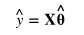

In [6]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # 모든 샘플에 x0 = 1을 추가합니다.
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

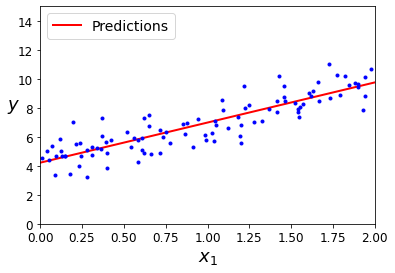

In [7]:

plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show()

In [8]:
# 사이킷런에서 선형 회귀 수행
# 사이킷런의 LinearRegression 클래스가 사용한 SVD 방법은 약 O(n제곱)이다. 특성의 수가 두 배로 늘어나면 계산 시간이 대략 4배가 된다. 

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_ #사이킷런은 특성의 가중치(coef)와 편항(intercept)를 분리하여 저장한다. 

(array([4.21509616]), array([[2.77011339]]))

In [9]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

In [10]:
# LinearRegression 클래스는 scipy.linalg.lstsq() 함수를 기반으로 한다. 
# 싸이파이 lstsq() 함수를 사용하려면 scipy.linalg.lstsq(X_b, y)와 같이 씁니다.

theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

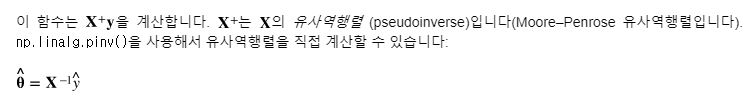

### inv vs pinv 

pinv()는 Moore - Penrose pseudo inverse of matrix를 반환한다. 반면에 inv()는 inverse of the matrix를 반환한다. 

inv()는 일반적인 inverse이다.  

A = m * n 행렬이라고 생각하고, B는 일반적인 inverse of A라고 생각해보면  이때  ABA = A는 만족한다. 

위의 식 ABA = A를 만족하는 matrix B를 Moore-Penrose pseudo inverse of matrix 라고 한다. 

B값은 matrix가 non-singular(invertible : 가역)일 때 unique한 값을 가집니다.

non - singular(invertible)일 때에는 pinv()와 inv()가 반환하는 값은 같다. 


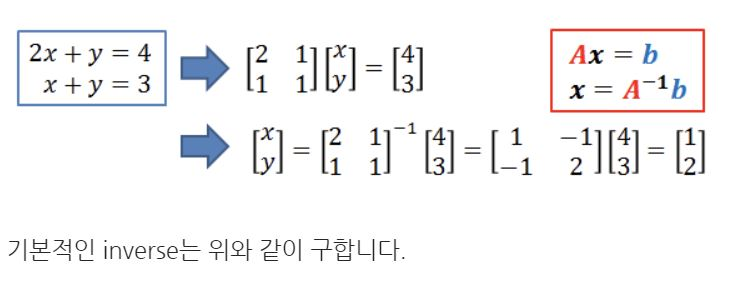



### SVD

유사역행렬 자체는 특잇값 분해라 부르는 표준 행렬 분해 기법을 사용해 계산된다. 

SVD는 훈련 세트 행렬 X를 3개의 행렬 곱셈으로 분해한다 -> numpy.linalg.svd()

=> 정규방정식과 SVD 방식 모두 특성 수가 많아지면 매우 느려지지만 샘플 수에 대해서는 선형적으로 증가하여

메모리 공간이 허락된다면 큰 훈련 세트도 효율적으로 처리할 수 있다. 

In [11]:
# 유사역행렬 직접 계산
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

# 4.2 경사하강법

여러 종류의 문제에서 최적의 해법을 찾을 수 있는 일반적인 최적화 알고리즘

비용 함수를 최소화하기 위해 반복해서 파라미터를 조정

파라미터 벡터에 대해 비용 함수의 현재 그레이디언트를 계산한다. 그리고 그레이디언트가 감소하는 방향으로 진행한다. 

=> 그레이디언트가 0이 되면 최솟값에 도달한 것이다.

즉 파라미터 벡터를 임의의 값으로 시작해서(무작위 초기화) 한 번에 조금씩 비용 함수가 감소되는 방향으로 진행하여

알고리즘이 최솟값에 수렴할 때까지 점진적으로 향상시킨다.

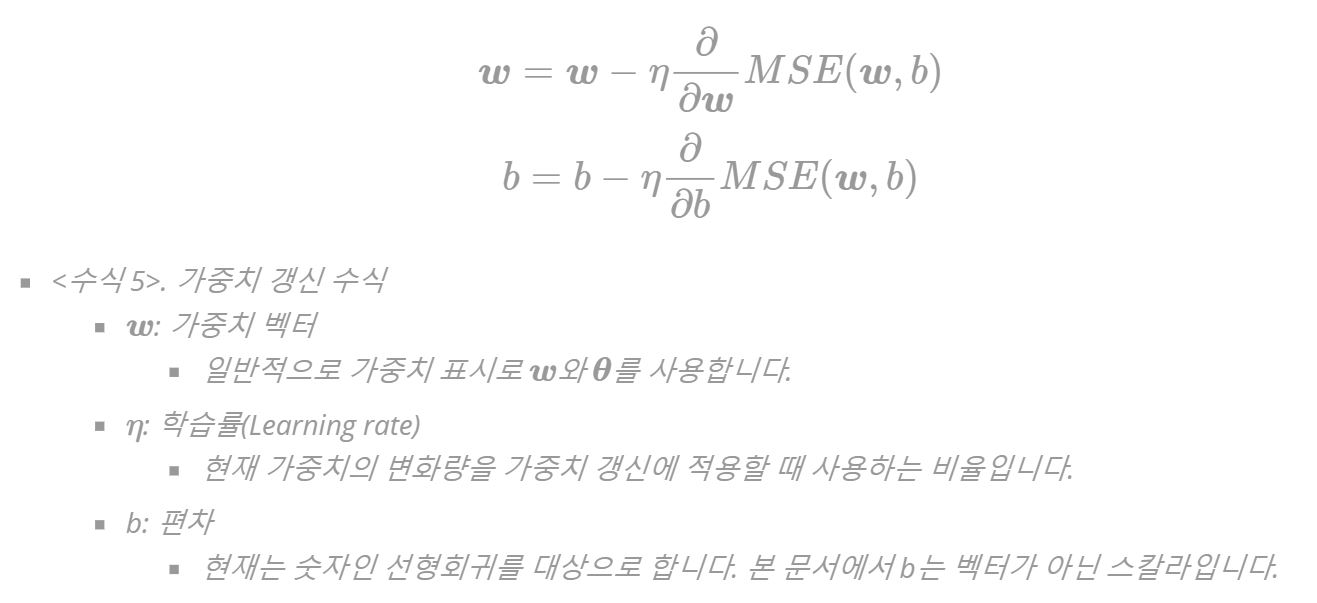

#### 학습률

따라서 경사 하강법에서 중요한 파라미터는 스텝의 크기로, 학습률 하이퍼파라미터로 결정된다. 

학습률이 너무 작으면 알고리즘이 수렴하기 위해 반복을 많이 진행해야 하므로 시간이 오래 걸린다. 

반대로 학습률이 너무 크면 알고리즘을 더 큰 값으로 발산하게 만들어 적절한 해법을 찾지 못하게 한다.

#### 주의

경사 하강법을 사용할 때는 반드시 모든 특성이 같은 스케일을 갖도록 만들어야 한다. 그렇지 않으면 수렴하는데 훨씬 오래 걸린다.

## 배치 경사 하강법 => 비용 함수의 편도함수

이 공식은 매 경사 하강법 스텝에서 전체 훈련 세트에 대해 계산한다.

즉 매 스텝에서 훈련 데이터 전체를 사용한다. 이런 이유로 큰 훈련 세트에서는 아주 느린다. 

그러나 경사 하강법은 특성 수에 민감하지 않다. 수십만 개의 특성에서 선형 회귀를 훈련키리려면 경사 하강법이 훨씬 편하다. 

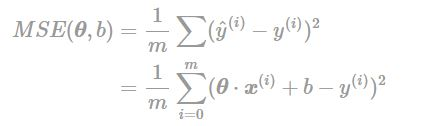

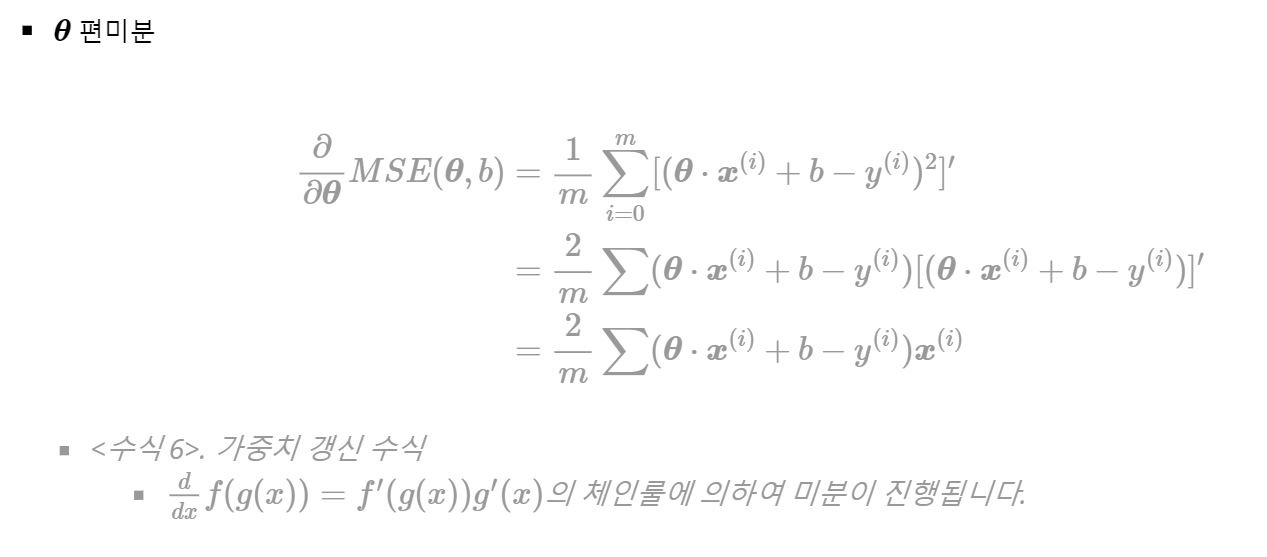

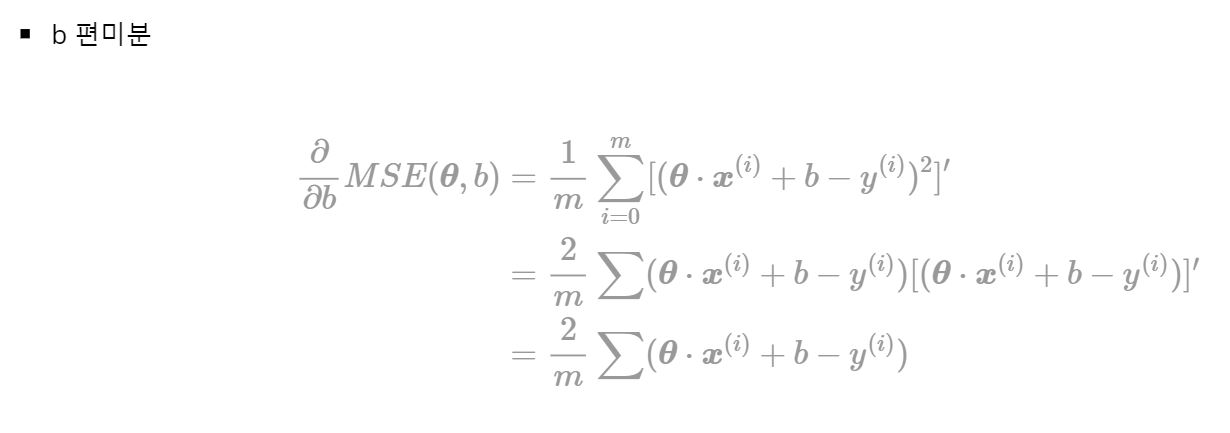

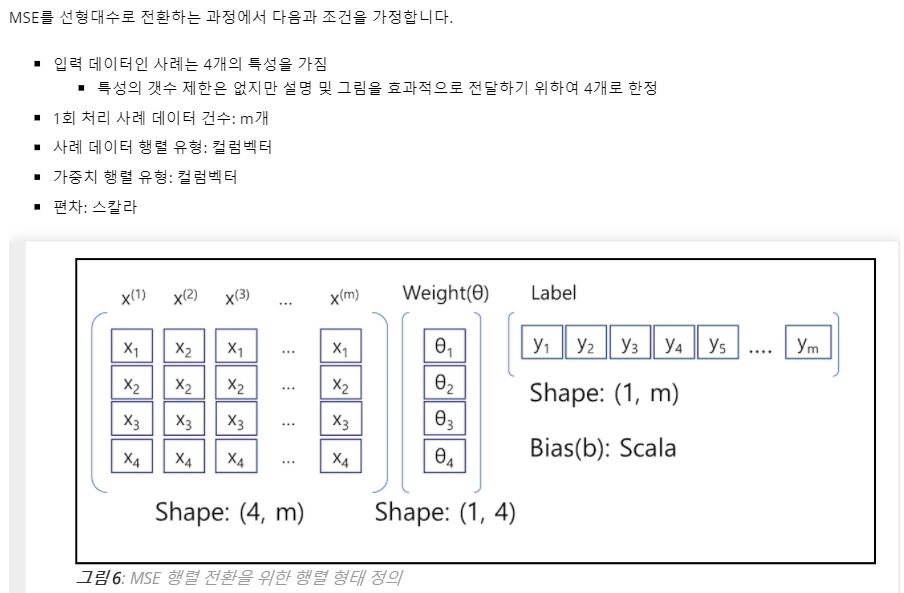


In [12]:
eta = 0.1  # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # 랜덤 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [13]:
theta

array([[4.21509616],
       [2.77011339]])

In [14]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

## 확률적 경사 하강법

In [16]:
# 확률적 경사 하강법 구현


n_epochs = 50
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # 랜덤 초기화

for epoch in range(n_epochs):
    for i in range(m):                      # m은 훈련 세트에 있는 샘플 수이다. 
        random_index = np.random.randint(m) #일반적으로 한 반복에서 m번 되풀이 되고, 이때 각 반복을 에포크라고 한다. 
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients      

In [17]:

from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

## 미니배치 경사 하강법

In [18]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [19]:
theta

array([[4.25214635],
       [2.7896408 ]])

# 4.3 다항회귀

비선형 데이터를 학습하는데 선형 모델을 사용할 수 있다. 

각 특성의 거듭게좁을 새로운 특성으로 추가하고, 이 확장된 특성을 포함한 데이터셋에 선형 모델을 훈련시키는 것이다. 

이를 다항 회귀라고 한다. 

In [21]:
# 2차 방정식으로 비선형 데이터 생성


m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

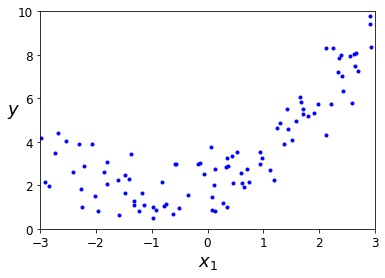

In [22]:

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [23]:
# PolynomialFeatures을 활용하여 훈련 데이터 변환
# PolynomialFeatures가 주어진 차수까지 특성 간의 모든 교차항을 추가한다. 
# PolynomialFeatures 매개변수 중 include_bias=True로 설정하면 편향을 위한 특성인 1이 추가된다. 
# 또 다른 매개변수로는 interaction_only=True로 지정하면 거듭제곱이 포함된 항은 모두 제거된다. 
# get_feature_names() 메서드를 호출하면 만들어진 특성의 차수를 쉽게 확인할 수 있다. 

from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([2.38942838])

In [24]:
# X_poly는 이제 원래 특성 X와 이 특성의 제곱을 포함한다. 
# 확장된 훈련 데이터에 LinearRegression 적용

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.9735233]), array([[0.95038538, 0.52577032]]))

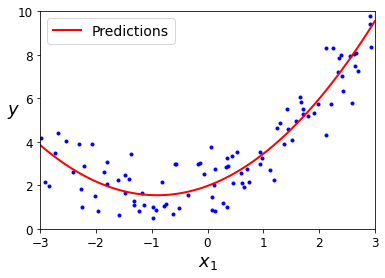

In [25]:

X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

In [28]:
# 훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기(또는 훈련 반복)의 함수로 나타낸다. 
# 훈련 데이터에서 모델의 학습 곡선을 그리는 함수 정의
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")

### 그래프 해석

1) 훈련 데이터 

과소적합된 모델 => 훈련 샘플을 추가해도 효과 없고, 더 복잡한 모델을 사용하거나 더 나은 특성을 선택해야 한다.

그래프가 0에서 시작하므로 훈련 세트에 하나 혹은 두 개의 샘플이 있을 땐 모델이 완벽하게 작동한다. 

하지만 훈련 세트에 샘플이 추가됨에 따라 잡음도 있고 비선형이기 때문에 모델이 훈련 데이터를 완벽하게 학습하는 것은 불가능해진다. 

=> 그래서 곡선이 어느 정도 평평해질 때까지 오차가 계속 상승한다. 

이 위치에서는 훈련 세트에 샘플이 추가되어도 평균 오차가 크게 나아지거나 나빠지지 않는다. 

2) 검증 데이터

적은 수의 훈련 샘플로 훈련될 때는 제대로 일반화될 수 없어서 검증 오차가 초기에는 매우 크다. 

모델에 훈련 샘플이 추가됨에 따라 학습이 되고, 검증 오차가 천천히 감소한다. 

그러나 선형 회귀의 직선은 데이터를 잘 모델링할 수 없으므로 오차의 감소가 완만해져서 훈련 세트의 그래프와 가까워진다. 


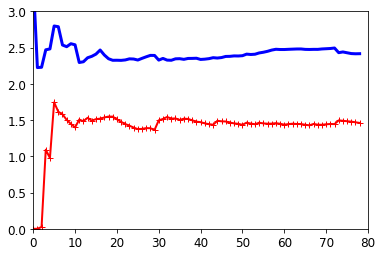

In [30]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # 책에는 없음
plt.show()   

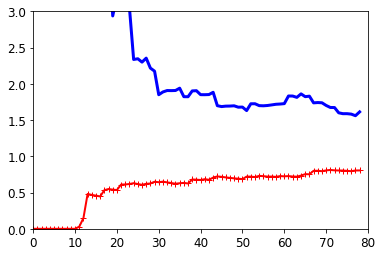

In [31]:
# 10차 다항 회귀 모델의 학습 곡선
# 두 가지 차이점 -> 1. 훈련 데이터의 오차가 선형 회귀 모델보다 훨씬 낮다. 
#                   2. 두 곡선 사이에 공간이 있다. 즉 훈련 데이터에서의 모델 성능이 검증 데이터에서보다 훨씬 낫다는 것(과대적합)-> 더 큰 훈련 세트를 사용하면 두 곡선이 점점 가까워진다.
#                   (과대적합을 개선하는 한 가지 방법=훈련 오차에 근접할 떄까지 더 많은 훈련 데이터를 추가한다.)

from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           
plt.show() 

### 편향/ 분산 트레이드오프

모델의 일반화 오차는 세 가지 다른 종류의 오차의 합으로 표현할 수 있다. 

1. 편향: 일반화 오차 중에서 잘못된 가정으로 인한 것. 예를 들어 데이터는 2차인데 선형으로 가정하는 경우

편향이 큰 모델은 훈련 데이터에 과소적합하기 쉽다. 

(선형 모델의 편향과 혼동하면 안된다)

2. 분산: 훈련 데이터에 있는 작은 변동에 모델이 과도하게 민감하기 때문에 나타난다. 

자유도가 높은 모델(예를 들면 고차 다항 회귀 모델)이 높은 분산을 가지기 쉬워 훈련 데이터에 과대적합되는 경향이 있다. 

3. 줄일 수 없는 오차

데이터 자체에 있는 잡음 때문에 발생한다. 줄일 수 있는 유일한 방법은 데이터에서 잡음을 제거하는 것이다. 

=> 모델의 복잡도가 커지면 통상적으로 분산이 늘어나고 편향이 줄어든다. 

=> 반대로 모델의 복잡도가 줄어들면 편향이 커지고 분산이 작아진다. 그래서 트레이드오프라고 한다. 